# HA Breathing

In [1]:
from __future__ import print_function
import pyemma
pyemma.__version__
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.weight':'medium', 
         'xtick.major.size':8,
         'ytick.major.size':8}
pylab.rcParams.update(params)
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as pplt
import numpy as np
import pickle 
import mdtraj as md
import itertools

Populating the interactive namespace from numpy and matplotlib


## Load coordinates

In [2]:
#2009 glycosylated HA
indir1 = '/net/gpfs-amarolab/lcasalino/FLU_MSM/pdm2009_H1N1/HA_trajectories/HA_trimers_head_alignment'
top1 =  indir1+'/HA.trimer.pdm.psf'
from glob import glob
trajs1 = glob ('/net/gpfs-amarolab/lcasalino/FLU_MSM/pdm2009_H1N1/HA_trajectories/HA_trimers_head_alignment/HA.trimer.*.pdm.head_aligned.dcd')

#2015 glycosylated HA
indir2 = '/net/gpfs-amarolab/lcasalino/FLU_MSM/michigan2015_H1N1/HA_trajectories/HA_trimers_head_alignment'
top2 =  indir2+'/../HA.trimer.michigan.psf'
from glob import glob
trajs2 = glob ('/net/gpfs-amarolab/lcasalino/FLU_MSM/michigan2015_H1N1/HA_trajectories/HA_trimers_head_alignment/HA.trimer.*.michigan.head_aligned.dcd')

## Select features and create input data types

#### Head breathing
We only need to create the features once, since we are using identical features across all trajectories.

In [3]:
#feature to find the smallest mean distance of the monomers to each other
def feature_1(traj: md.Trajectory):
    full1 = np.array([0], dtype=float32) #default is int64 which causes problems when loading coordinates
    full2 = np.array([0], dtype=float32)
    full3 = np.array([0], dtype=float32)
    full4 = np.array([0], dtype=float32)
    centers1 = COM_top1.transform(traj)  # yields ndarray
    centers2 = COM_top2.transform(traj)
    centers3 = COM_top3.transform(traj)
    centers4 = central_top.transform(traj)  # yields ndarray
    for i, j in zip(centers1, centers4):
        com1 = np.linalg.norm(np.subtract(i,j))
        full1 = np.append(full1, com1)
    reshaped1 = np.reshape(full1, (-1, 1))
    reshaped1 = reshaped1[1:]
    reshaped1 = reshaped1.astype('float32')
    for i, j in zip(centers2, centers4):
        com2 = np.linalg.norm(np.subtract(i,j))
        full2 = np.append(full2, com2)
    reshaped2 = np.reshape(full2, (-1, 1))
    reshaped2 = reshaped2[1:]
    reshaped2 = reshaped2.astype('float32')
    for i, j in zip(centers3, centers4):
        com3 = np.linalg.norm(np.subtract(i,j))
        full3 = np.append(full3, com3)
    reshaped3 = np.reshape(full3, (-1, 1))
    reshaped3 = reshaped3[1:]
    reshaped3 = reshaped3.astype('float32')
    minimum1 = np.hstack((reshaped1, reshaped2, reshaped3))
    minimum2 = np.mean(minimum1, axis=1)
    minimum3 = np.asarray(minimum2)
    minimum4 = np.reshape(minimum3, (-1, 1))
    minimum4 = minimum4.astype('float32')
    return minimum4

In [4]:
#this should work!!! we need the alpha carbons though
feat_breathing_2009g = pyemma.coordinates.featurizer(top1)

tip1 = feat_breathing_2009g.topology.select('resid 140 to 165 and name CA')
tip2 = feat_breathing_2009g.topology.select('resid 700 to 740 and name CA')
tip3 = feat_breathing_2009g.topology.select('resid 1260 to 1300 and name CA')
central_tip = feat_breathing_2009g.topology.select('resid 227 793 1357 and name CA')

from pyemma.coordinates.data.featurization.misc import GroupCOMFeature

COM_top1 = GroupCOMFeature(feat_breathing_2009g.topology, [tip1])
COM_top2 = GroupCOMFeature(feat_breathing_2009g.topology, [tip2])
COM_top3 = GroupCOMFeature(feat_breathing_2009g.topology, [tip3])
central_top = GroupCOMFeature(feat_breathing_2009g.topology, [central_tip])

feat_breathing_2009g.add_custom_func(feature_1, dim=1, description='breathing')

print(feat_breathing_2009g.dimension())
print(feat_breathing_2009g.describe())
print(type(feat_breathing_2009g))

1
['breathing']
<class 'pyemma.coordinates.data.featurization.featurizer.MDFeaturizer'>


In [5]:
feat_breathing_2015g = pyemma.coordinates.featurizer(top2)

tip1 = feat_breathing_2015g.topology.select('resid 140 to 165 and name CA')
tip2 = feat_breathing_2015g.topology.select('resid 700 to 740 and name CA')
tip3 = feat_breathing_2015g.topology.select('resid 1260 to 1300 and name CA')
central_tip = feat_breathing_2015g.topology.select('resid 227 793 1357 and name CA')

from pyemma.coordinates.data.featurization.misc import GroupCOMFeature

COM_top1 = GroupCOMFeature(feat_breathing_2015g.topology, [tip1])
COM_top2 = GroupCOMFeature(feat_breathing_2015g.topology, [tip2])
COM_top3 = GroupCOMFeature(feat_breathing_2015g.topology, [tip3])
central_top = GroupCOMFeature(feat_breathing_2015g.topology, [central_tip])

feat_breathing_2015g.add_custom_func(feature_1, dim=1, description='breathing')

print(feat_breathing_2015g.dimension())
print(feat_breathing_2015g.describe())
print(type(feat_breathing_2015g))

1
['breathing']
<class 'pyemma.coordinates.data.featurization.featurizer.MDFeaturizer'>


Load the coordinates of each dataset as a function of the features we selected above into the memory (this takes maybe 20-30 minutes)

We will also print some info about the data we loaded to make sure we are loading the correct trajectories. The shape of the first element should show the number of frames it has and the number of features we selected. This can take 10 minutes.

In [6]:
#lag time here doesn't really matter
print("2009 glycosylated HA")
data_2009_glycosylated = pyemma.coordinates.load(trajs1, features=feat_breathing_2009g)
print('trajectory time step = .06 ns')
print("data_2009_glycosylated has",len(data_2009_glycosylated), "trajectories")
print("data_2009_glycosylated has",(data_2009_glycosylated[0].shape[0]), "frames in the first trajectory")
print("data_2009_glycosylated has",(data_2009_glycosylated[0].shape[1]), "features")

print("2015 glycosylated HA")
data_2015_glycosylated = pyemma.coordinates.load(trajs2, features=feat_breathing_2015g)
print('trajectory time step = .06 ns')
print("data_2015_glycosylated has",len(data_2015_glycosylated), "trajectories")
print("data_2015_glycosylated has",(data_2015_glycosylated[0].shape[0]), "frames in the first trajectory")
print("data_2015_glycosylated has",(data_2015_glycosylated[0].shape[1]), "features")

2009 glycosylated HA


trajectory time step = .06 ns
data_2009_glycosylated has 236 trajectories
data_2009_glycosylated has 7363 frames in the first trajectory
data_2009_glycosylated has 1 features
2015 glycosylated HA


trajectory time step = .06 ns
data_2015_glycosylated has 236 trajectories
data_2015_glycosylated has 7083 frames in the first trajectory
data_2015_glycosylated has 1 features


Let's save the data types created so we can load them later (and then load them for use)

In [7]:
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/data_2009_glycosylated.txt', 'wb') as fp:
    pickle.dump(data_2009_glycosylated, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/data_2009_glycosylated.txt', 'rb') as fp:
    data_2009_glycosylated = pickle.load(fp)
    
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/data_2015_glycosylated.txt', 'wb') as fp:
    pickle.dump(data_2015_glycosylated, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/data_2015_glycosylated.txt', 'rb') as fp:
    data_2015_glycosylated = pickle.load(fp)

## Reducing the feature dimension using TICA

Let's create the TICA object from our original data. Note, we are only going to use the 2009 unglycosylated dataset to create the TICA space in our analyses. We are just creating TICA space for the other two datasets to compare with later on. Note, this tICA lag time must be shorter than or equal to the MSM lag time.

In [8]:
print("2009 glycosylated dataset")
tica_obj_2009g = coor.tica(data_2009_glycosylated, lag=100, kinetic_map=False, var_cutoff=0.95, reversible=True) #lag time in steps (.02ns/step)
print(tica_obj_2009g.describe())
print("2015 glycosylated dataset")
tica_obj_2015g = coor.tica(data_2015_glycosylated, lag=100, kinetic_map=False, var_cutoff=0.95, reversible=True) #lag time in steps (.02ns/step)
print(tica_obj_2015g.describe())

2009 glycosylated dataset


[TICA, lag = 100; max. output dim. = 1]
2015 glycosylated dataset


[TICA, lag = 100; max. output dim. = 1]


These functions will (1) map the input data of the transformer and return it as a list of arrays, and (2) concatenate that list into a numpy array

In [9]:
tica_output_2009g = tica_obj_2009g.get_output()
tica_concatenated_2009g = np.concatenate(tica_output_2009g)
tica_output_2015g = tica_obj_2015g.get_output()
tica_concatenated_2015g = np.concatenate(tica_output_2015g)

The concatenated datasets below are a tuple. What is the first list and what is the second list? The first list is the number of frames in the dataset, and the second is the tICs - we show each of these in two ways below for validation.

In [10]:
print("The 2009 unglycosylated dataset has",(tica_obj_2009g.n_frames_total()),"frames")
print("The 2009 unglycosylated dataset has",(tica_concatenated_2009g.shape[0]),"frames")
print("The 2009 unglycosylated dataset has",(tica_obj_2009g.dimension()),"dimensions")
print("The 2009 unglycosylated dataset has",(tica_concatenated_2009g.shape[1]),"dimensions")

The 2009 unglycosylated dataset has 1737668 frames
The 2009 unglycosylated dataset has 1737668 frames
The 2009 unglycosylated dataset has 1 dimensions
The 2009 unglycosylated dataset has 1 dimensions


Now we can describe the tuple that is our concatenated output datasets, remembering that TICA dimensions are the TICA internal coordinates.

In [11]:
print("The 2009 glycosylated dataset has",(tica_concatenated_2009g.shape[0]),"frames and",(tica_concatenated_2009g.shape[1]),"tICs")
print("The 2015 glycosylated dataset has",(tica_concatenated_2015g.shape[0]),"frames and",(tica_concatenated_2015g.shape[1]),"tICs")

The 2009 glycosylated dataset has 1737668 frames and 1 tICs
The 2015 glycosylated dataset has 1671588 frames and 1 tICs


With the TICA coordinates selected above, we want to see if there's a noticeable jump between states. Here, we are qualitatively looking to see the line jump up and down, or perhaps stay down or up for some extended period of time. We do not want to see a flat line right down the middle. For clarity, we will only look at the first 100 trajectories from each dataset.

The first 30 trajectories of the 2009 glycosylated dataset contain 1737668 frames
The first 30 trajectories of the 2015 glycosylated dataset contain 1671588 frames


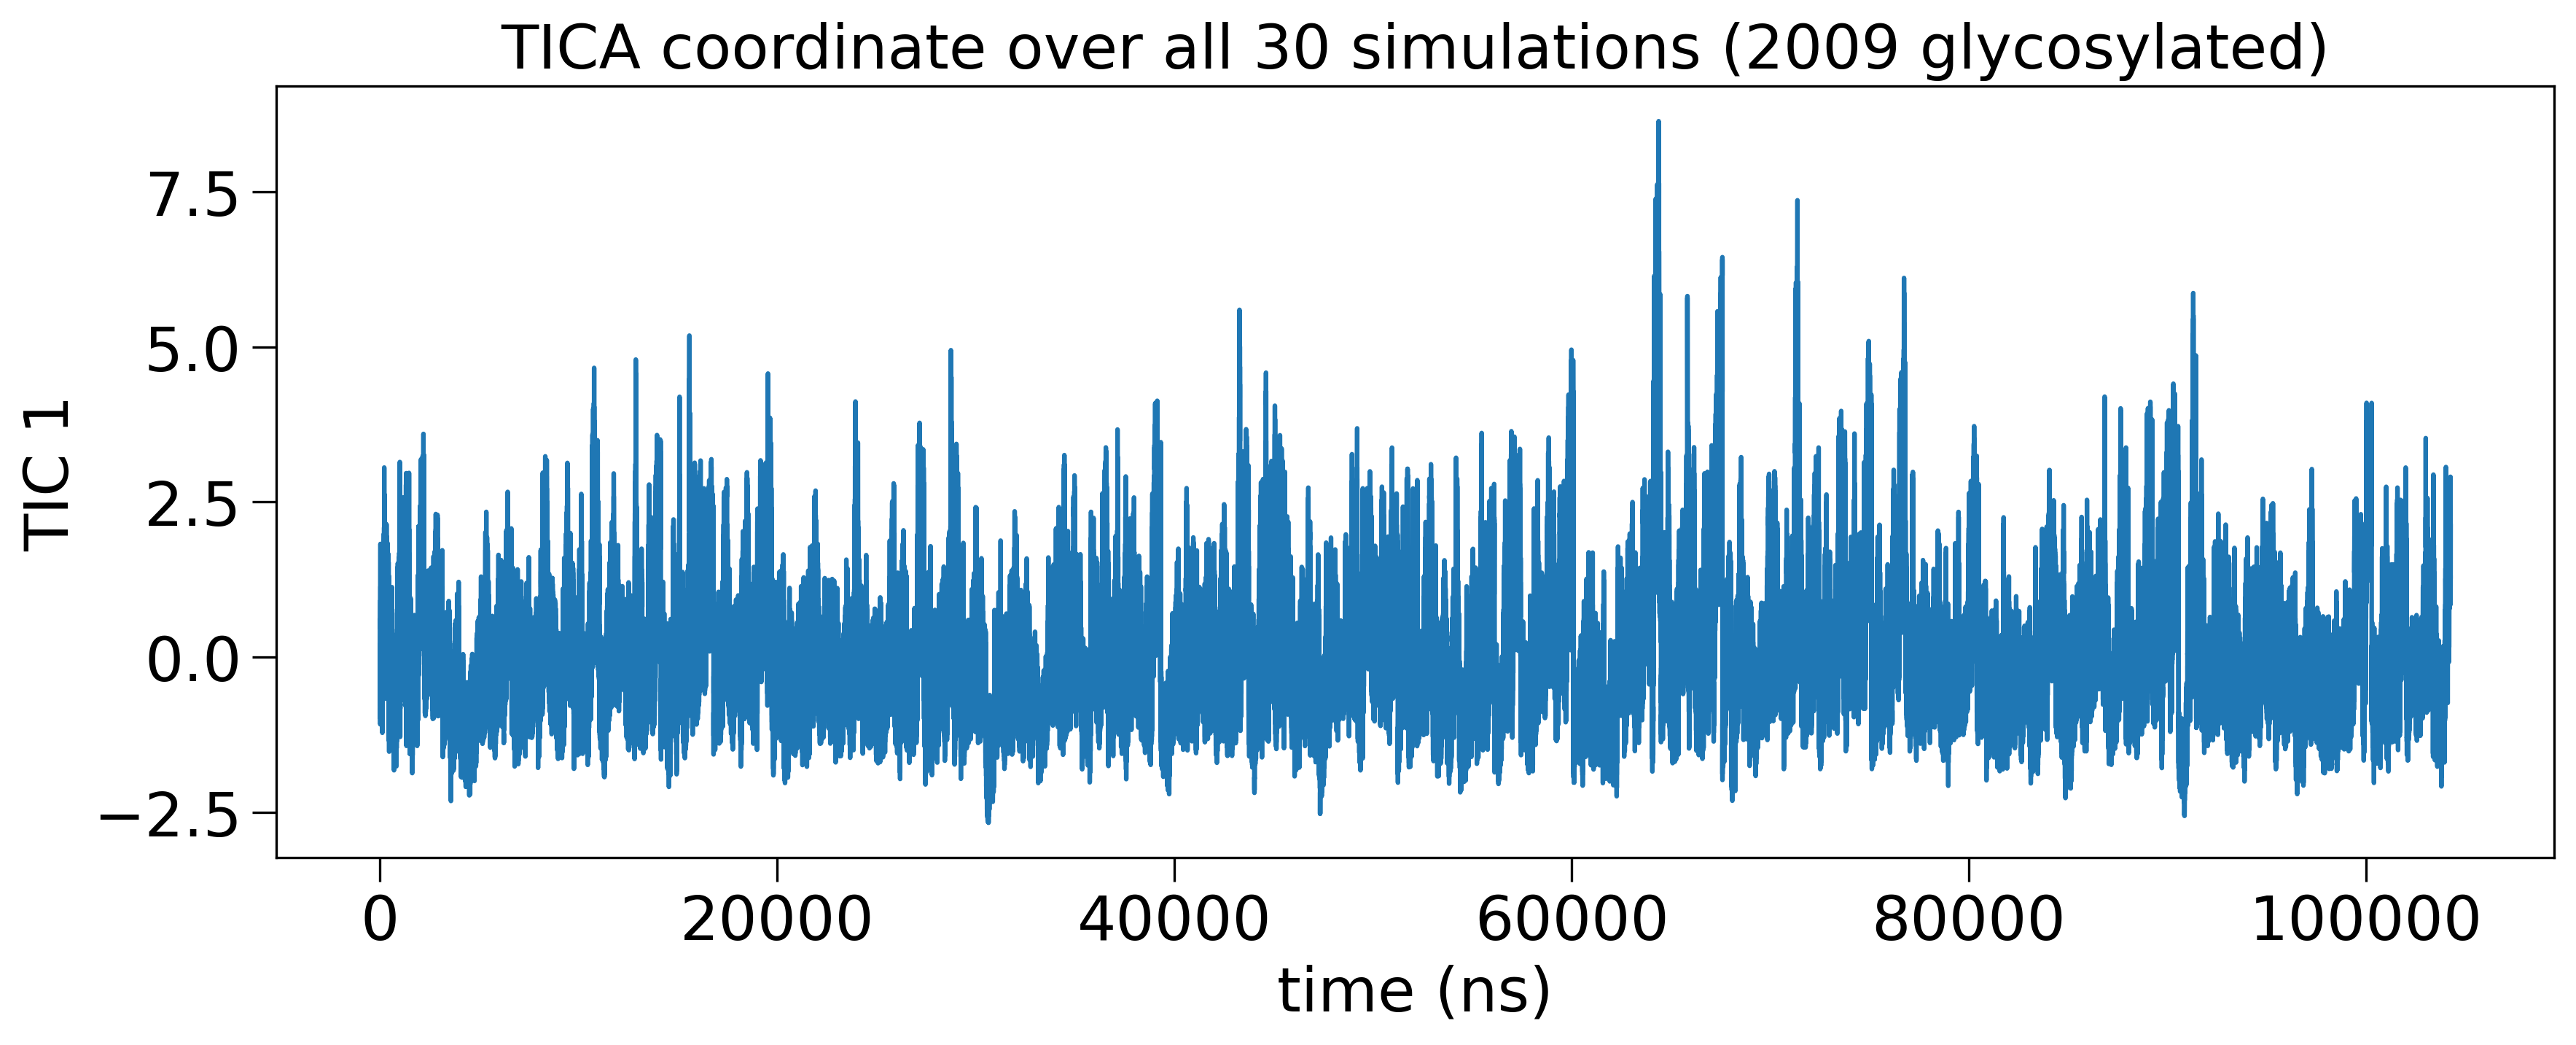

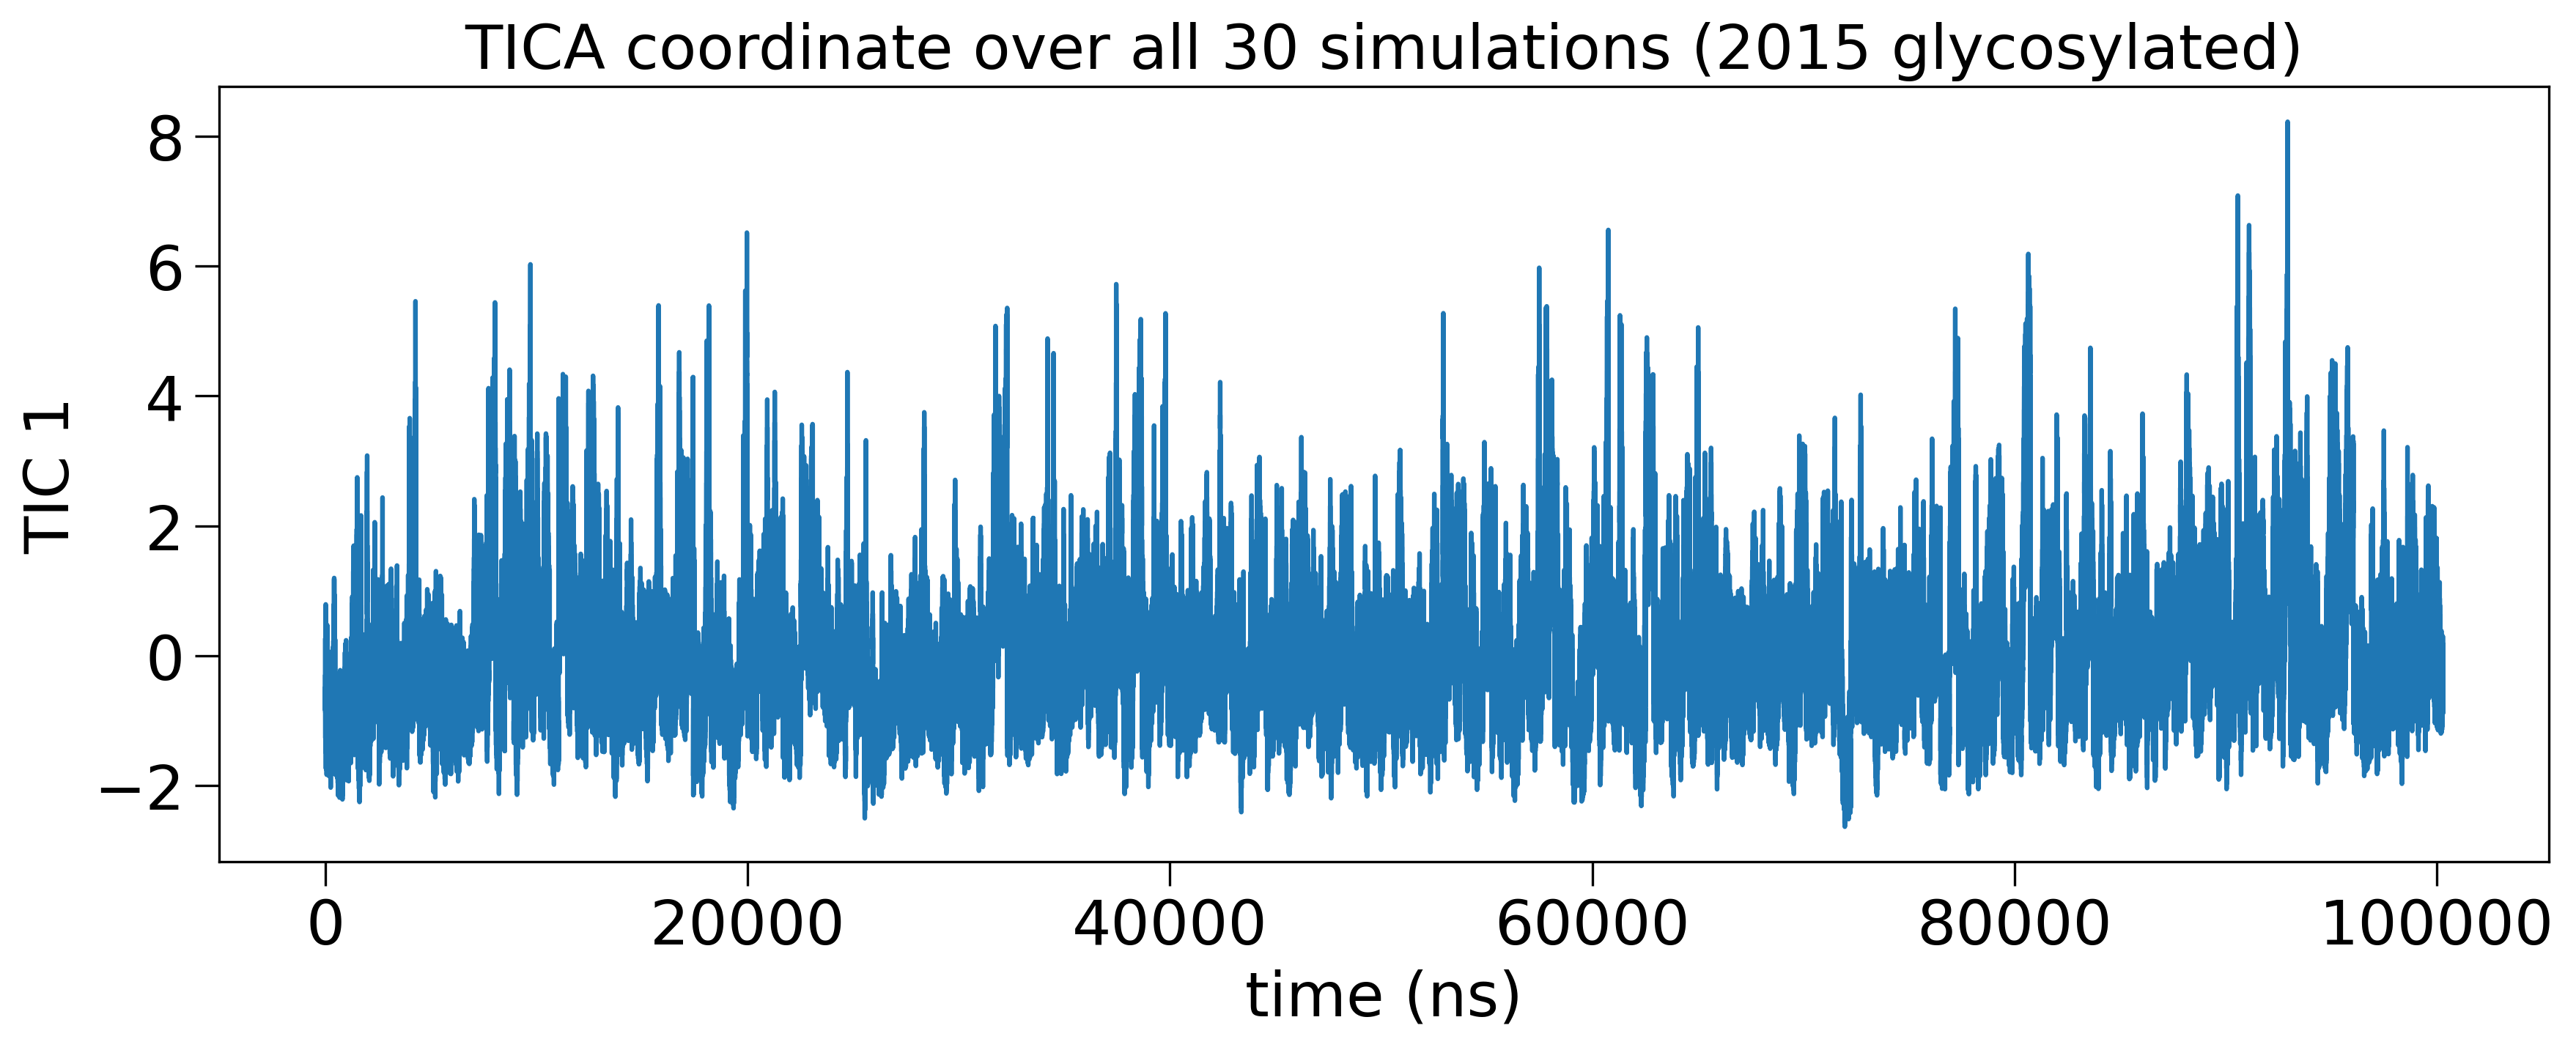

In [12]:
#2009 glycosylated
all_30_sims_2009g = np.concatenate(tica_output_2009g, axis=0)
plt.figure(figsize=(12,5), dpi=300)
matplotlib.rcParams.update({'font.size': 14})
dt = 0.06
x = dt*np.arange(all_30_sims_2009g.shape[0])
plt.title('TICA coordinate over all 30 simulations (2009 glycosylated)')
plot(x, all_30_sims_2009g[:,0]); ylabel('TIC 1'); xlabel('time (ns)')
plt.tight_layout()
plt.savefig('//net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/figures/tica_2009g.png',dpi=300)
print("The first 30 trajectories of the 2009 glycosylated dataset contain",all_30_sims_2009g.shape[0],"frames")

#2015 glycosylated
all_30_sims_2015g = np.concatenate(tica_output_2015g, axis=0)
plt.figure(figsize=(12,5), dpi=300)
matplotlib.rcParams.update({'font.size': 14})
dt = 0.06
x = dt*np.arange(all_30_sims_2015g.shape[0])
plt.title('TICA coordinate over all 30 simulations (2015 glycosylated)')
plot(x, all_30_sims_2015g[:,0]); ylabel('TIC 1'); xlabel('time (ns)')
plt.tight_layout()
plt.savefig('//net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/figures/tica_2015g.png',dpi=300)
print("The first 30 trajectories of the 2015 glycosylated dataset contain",all_30_sims_2015g.shape[0],"frames")

The 2009 glycosylated and 2015 glycosylated datasets contain over twice as many frames in their first 100 trajectories as the 2009 unglycosylated dataset; consequently, those transitions are much clearer.

In [13]:
with open('//net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/tica_output_2009g.txt', 'wb') as fp:
    pickle.dump(tica_output_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/tica_concatenated_2009g.txt', 'wb') as fp:
    pickle.dump(tica_concatenated_2009g, fp) 
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/tica_output_2015g.txt', 'wb') as fp:
    pickle.dump(tica_output_2015g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/tica_concatenated_2015g.txt', 'wb') as fp:
    pickle.dump(tica_concatenated_2015g, fp) 
    
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/tica_output_2009g.txt', 'rb') as fp:
    tica_output_2009g = pickle.load(fp) 
with open ('//net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/tica_concatenated_2009g.txt', 'rb') as fp:
    tica_concatenated_2009g = pickle.load(fp) 
with open ('//net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/tica_output_2015g.txt', 'rb') as fp:
    tica_output_2015g = pickle.load(fp) 
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/tica_concatenated_2015g.txt', 'rb') as fp:
    tica_concatenated_2015g = pickle.load(fp) 

## Clustering

The next step is to use this reduced-dimensions data to cluster our data, and create the discrete trajectories (dtrajs) as a function of the k-means cluster centers. You can see how the data is spread over the energy landscape in the graph below, where we are plotting the free energy landscape with the cluster centers (in black); this can take maybe 15 minutes to run. We select 300 clusters (k=300) and 24 processors to run (n_jobs=24)

In [14]:
#2009 glycosylated 70 iters doesn't work??
clk_2009g = coor.cluster_kmeans(tica_output_2009g, k=300, max_iter=150, n_jobs=32, fixed_seed=True)
dtrajs_2009g = clk_2009g.dtrajs

#2015 glycosylated
clk_2015g = coor.cluster_kmeans(tica_output_2015g, k=300, max_iter=150, n_jobs=32, fixed_seed=True)
dtrajs_2015g = clk_2015g.dtrajs

With the discrete trajectories created, let's save and then load them:

In [15]:
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/clk_2009g.txt', 'wb') as fp:
    pickle.dump(clk_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/dtrajs_2009g.txt', 'wb') as fp:
    pickle.dump(dtrajs_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/clk_2015g.txt', 'wb') as fp:
    pickle.dump(clk_2015g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/dtrajs_2015g.txt', 'wb') as fp:
    pickle.dump(dtrajs_2015g, fp)
    
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/clk_2009g.txt', 'rb') as fp:
    clk_2009g = pickle.load(fp) 
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/dtrajs_2009g.txt', 'rb') as fp:
    dtrajs_2009g = pickle.load(fp) 
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/clk_2015g.txt', 'rb') as fp:
    clk_2015g = pickle.load(fp) 
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/dtrajs_2015g.txt', 'rb') as fp:
    dtrajs_2015g = pickle.load(fp) 

## MSM creation 

It's important that the lag time used in the cell below (the MSM lag time) is equal to or larger than the TICA lag time (seen in the coor.tica cell much earlier - we selected a TICA lag time of 500 steps). TICA can only resolve motions longer than its lag time, because a motion shorter than the lag time is simply not seen. This is why it only makes sense to choose an MSM lag time that is equal to or larger than the TICA lag time. From all this, we will select an MSM lag time of 500 steps, which is roughly where the lines flatten out. Now let's go ahead and create an MSM at the lag time we selected.

### original MSM 

Now let's look at the implied timescales for the MSM. Here we are selecting six macrostates with a lag time of 10000 steps. This took maybe 10 minutes. After seeing the timescale separation plot, I redid this step, changing around the number of states selected.

In [16]:
#2009 glycosylated
its = msm.timescales_msm(dtrajs_2009g, lags=10000, nits=5, n_jobs=32, errors='bayes') #errors='bayes'
pplt.plot_implied_timescales(its, units='steps', nits=10, linewidth=2) #units can be ns if desired
plt.title('Implied Timescale Plot with Errors 2009g')
plt.xlabel('Lag Time (steps)', fontsize=24)
plt.ylabel('Timescale (steps)', fontsize=24)
plt.savefig('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/figures/its_msm_2009g.png', dpi=300)
plt.figure()

#2015 glycosylated
its = msm.timescales_msm(dtrajs_2015g, lags=10000, nits=5, n_jobs=32, errors='bayes') #errors='bayes'
pplt.plot_implied_timescales(its, units='steps', nits=10, linewidth=2) #units can be ns if desired
plt.title('Implied Timescale Plot with Errors 2015g')
plt.xlabel('Lag Time (steps)', fontsize=24)
plt.ylabel('Timescale (steps)', fontsize=24)
plt.savefig('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/figures/its_msm_2015g.png', dpi=300)
plt.figure()

01-10-22 18:22:38 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[14] WARNING  Ignoring lag times that exceed the longest trajectory: [ 8091 10000]


01-10-22 18:32:36 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[16] WARNING  Ignoring lag times that exceed the longest trajectory: [ 8091 10000]


<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

It's important that the lag time used in the cell below (the MSM lag time) is equal to or larger than the TICA lag time (seen in the coor.tica cell much earlier - we selected a TICA lag time of 500 steps). TICA can only resolve motions longer than its lag time, because a motion shorter than the lag time is simply not seen. This is why it only makes sense to choose an MSM lag time that is equal to or larger than the TICA lag time. From all this, we will select an MSM lag time of 500 steps, which is roughly where the lines start to flatten out.

Let's create an Bayesian MSM for each dataset:

In [17]:
msm_2009g = msm.bayesian_markov_model(dtrajs_2009g, 500, reversible=True)
msm_2015g = msm.bayesian_markov_model(dtrajs_2015g, 500, reversible=True)

Now let's save the MSM data and reload it:

In [18]:
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2009g.txt', 'wb') as fp:
    pickle.dump(msm_2009g, fp)
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2009g.txt', 'rb') as fp:
    msm_2009g = pickle.load(fp) 
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2015g.txt', 'wb') as fp:
    pickle.dump(msm_2015g, fp)
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2015g.txt', 'rb') as fp:
    msm_2015g = pickle.load(fp) 

Each dot on this plot shows the timescale separation between one metastable state and the following metastable state. Thus the first dot shows the timescale separation between the first metastable state and the second metastable state, which corresponds to one slow motion. We want to pick all of the dots that are separated from each other, which is a qualitative task. If your selections don't generate interesting slow motions you can select more, but the dots with low separation (~1) represent the overlapping lines on the implied timescale plot, so they likely represent the same motion.

<Figure size 1080x1080 with 0 Axes>

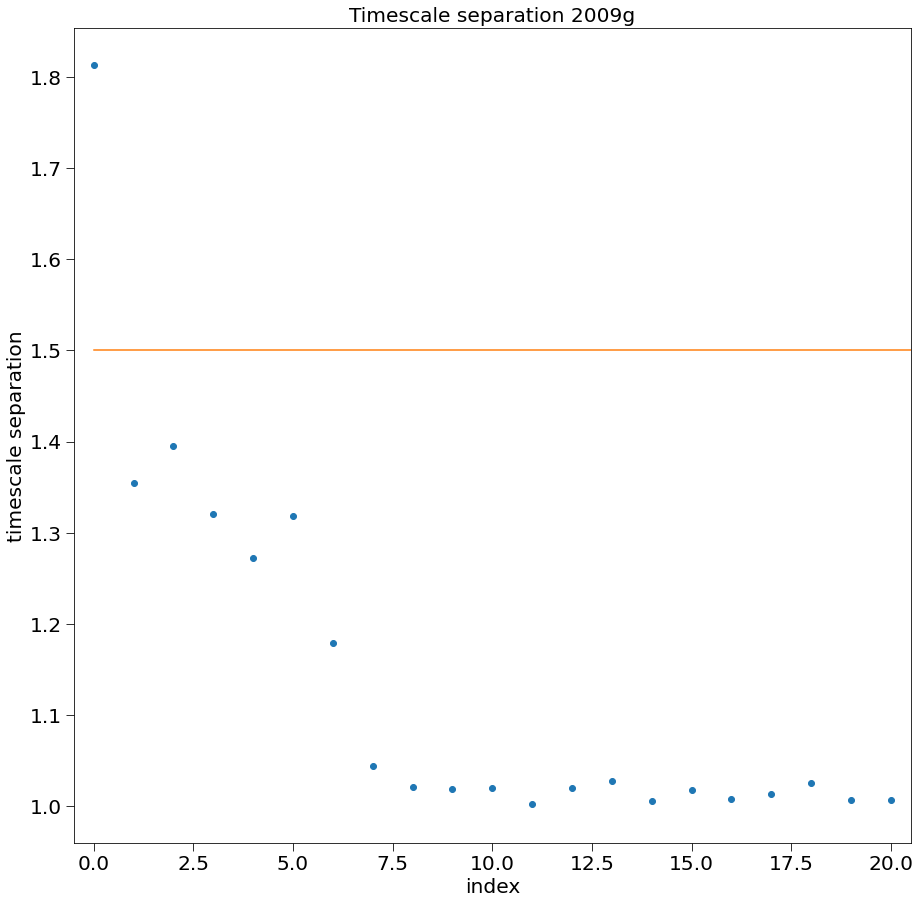

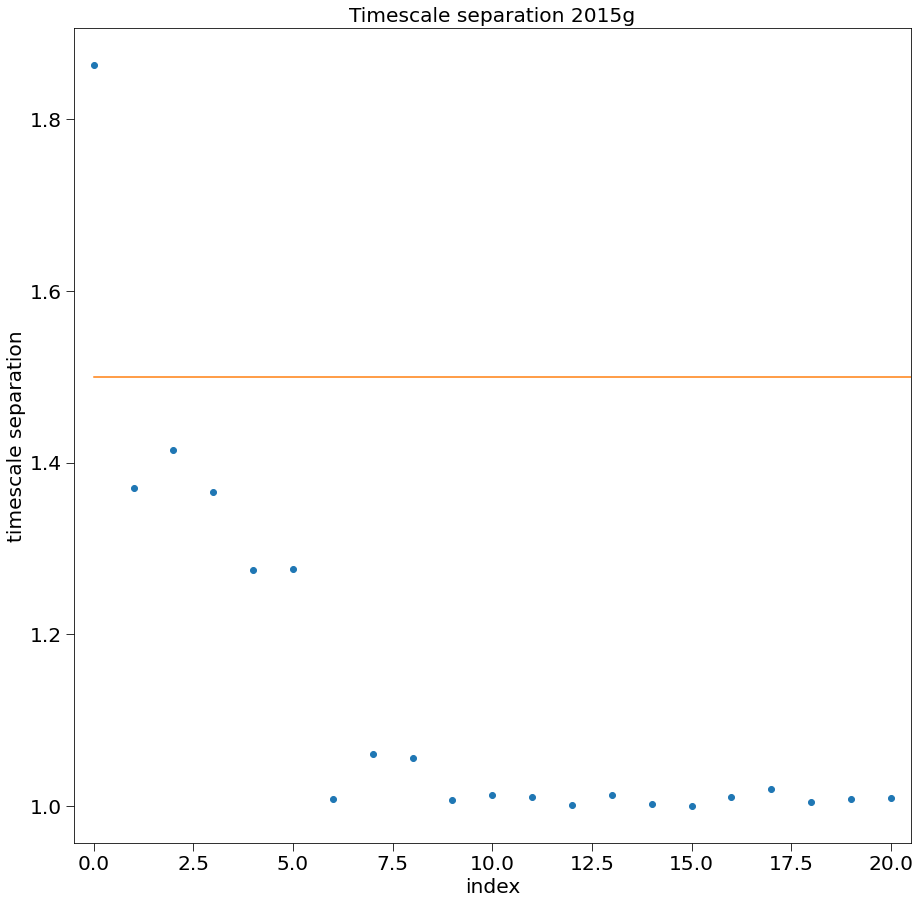

<Figure size 1080x1080 with 0 Axes>

In [19]:
#2009 glycosylated
plot(msm_2009g.timescales()[:-1]/msm_2009g.timescales()[1:], linewidth=0,marker='o')
plot(np.full(len(msm_2009g.timescales()[:-1]/msm_2009g.timescales()[1:]), 1.5))
plt.title('Timescale separation 2009g')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,20.5)
plt.figure()

#2015 glycosylated
plot(msm_2015g.timescales()[:-1]/msm_2015g.timescales()[1:], linewidth=0,marker='o')
plot(np.full(len(msm_2015g.timescales()[:-1]/msm_2015g.timescales()[1:]), 1.5))
plt.title('Timescale separation 2015g')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,20.5)
plt.figure()

For the 2009 dataset, dot with index 0 (the 1st dot overall) is the last dot with a decent timescale separation (>1.5), so we would normally choose 1 dot on our first try. From iterating we know that we need to choose 1 dot to see our interesting slow motion. Choosing 1 dot means that we are choosing 3 metastable states, which correspond to 2 slow motions. This is a qualitative method to estimate how many states you should choose. A better method would be to examine the stationary distribution, which we will do later.

Now let's run the CK test on the six macrostates that we chose above This test estimates if you would still predict the same transition given an infinite lag time. We will run with 32 processors. Note: the mlags tells how long of a lag time to calculate. If the implied timescale plot shows the lines running into the forbidden region after lag time of 5, you would not want to choose an mlags greater than 5 here.

If you get an error that says "index 297 is out of bounds for axis 0 with size 297" that means you need to select a smaller lag

CPU times: user 31.3 s, sys: 34.3 s, total: 1min 5s
Wall time: 3min 24s


CPU times: user 29.7 s, sys: 34.3 s, total: 1min 4s
Wall time: 3min 41s


<Figure size 1080x1080 with 0 Axes>

<Figure size 3600x2700 with 0 Axes>

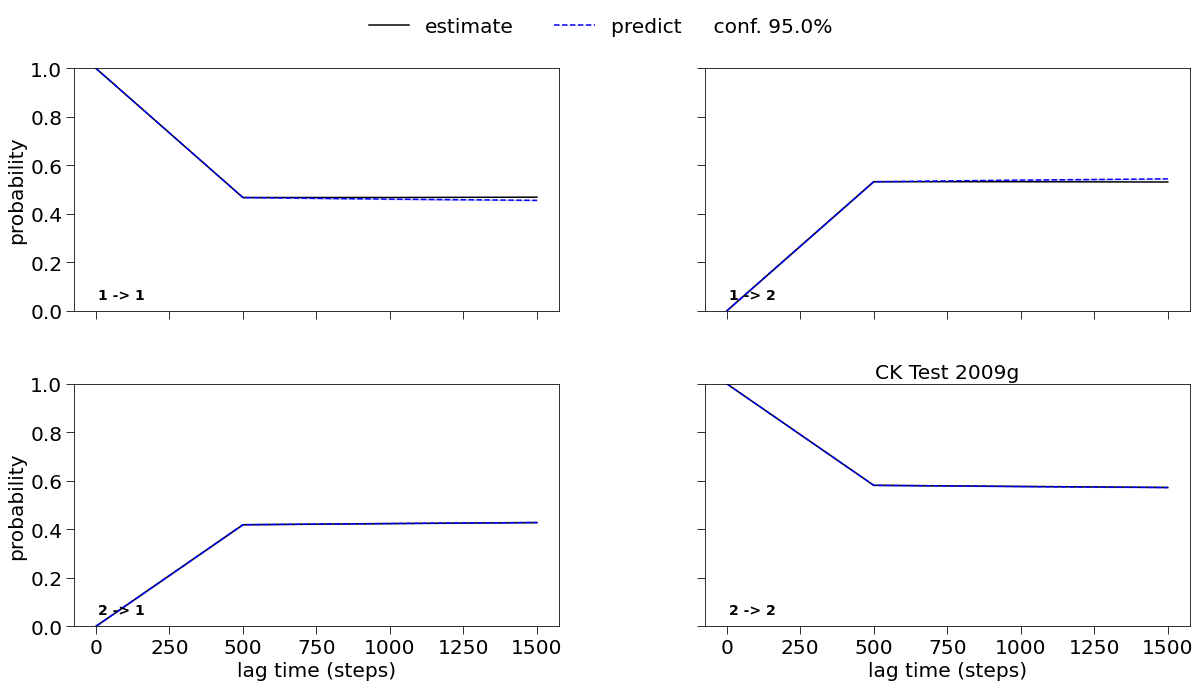

<Figure size 1080x1080 with 0 Axes>

<Figure size 3600x2700 with 0 Axes>

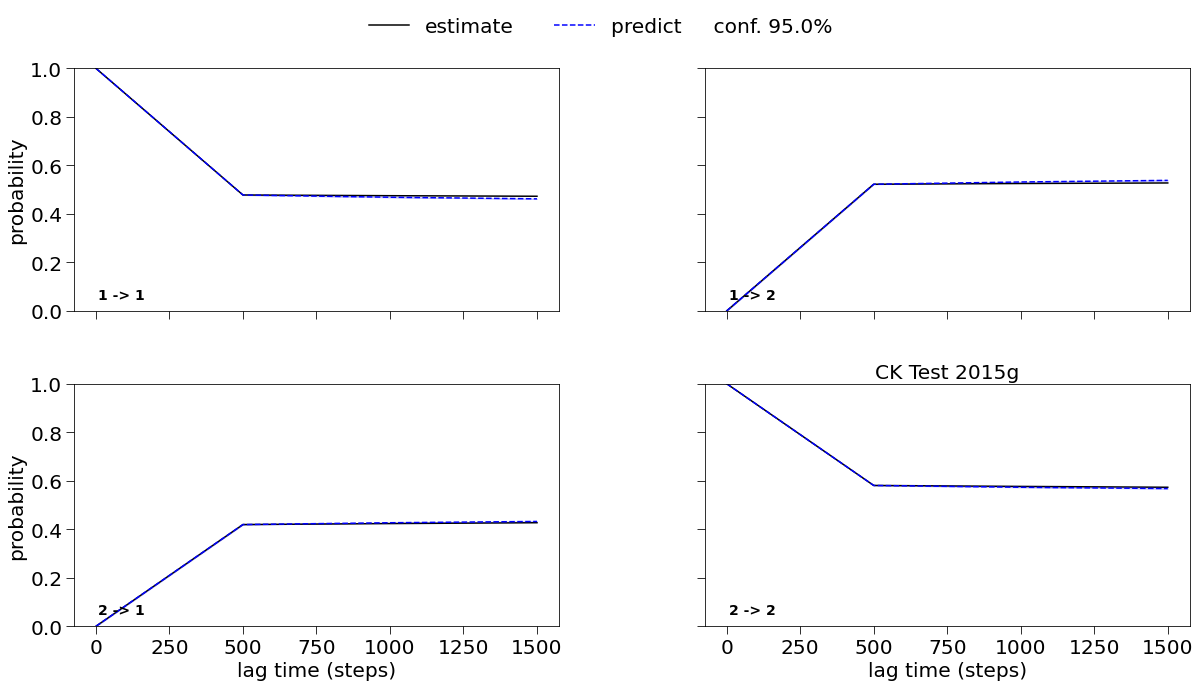

<Figure size 1080x1080 with 0 Axes>

In [20]:
#2009 glycosylated
%time ck_2009g = msm_2009g.cktest(2, memberships=None, mlags=4, conf=0.95, err_est=False, n_jobs=32, show_progress=True)
plt.figure(figsize=(12,9), dpi=300)
matplotlib.rcParams.update({'font.size': 14})
pplt.plot_cktest(ck_2009g, diag=False, figsize=(20,10), layout=(4,4), padding_top=0.1, y01=True, padding_between=0.3, dt=1.0, units='steps')
plt.title('CK Test 2009g')
plt.savefig('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/figures/ck_msm_2009g.png')
plt.figure()

#2015 glycosylated
%time ck_2015g = msm_2015g.cktest(2, memberships=None, mlags=4, conf=0.95, err_est=False, n_jobs=32, show_progress=True)
plt.figure(figsize=(12,9), dpi=300)
matplotlib.rcParams.update({'font.size': 14})
pplt.plot_cktest(ck_2015g, diag=False, figsize=(20,10), layout=(4,4), padding_top=0.1, y01=True, padding_between=0.3, dt=1.0, units='steps')
plt.title('CK Test 2015g')
plt.savefig('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/figures/ck_msm_2015g.png')
plt.figure()

In [21]:
#2009 glycosylated
nstates = 2
print("The 2009 glycosylated stationary distribution is:")
msm_2009g.pcca(nstates)
for i, s in enumerate(msm_2009g.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm_2009g.pi[s].sum()))

#2015 glycosylated
nstates = 2
print("The 2015 glycosylated stationary distribution is:")
msm_2015g.pcca(nstates)
for i, s in enumerate(msm_2015g.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm_2015g.pi[s].sum()))

The 2009 glycosylated stationary distribution is:
π_1 = 0.250430
π_2 = 0.749570
The 2015 glycosylated stationary distribution is:
π_1 = 0.269255
π_2 = 0.730745


In [22]:
nstates = 2
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm_2009g.mfpt(
            msm_2009g.metastable_sets[i],
            msm_2009g.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
display(DataFrame(np.round(mfpt, decimals=2), index=range(0, nstates), columns=range(0, nstates)).multiply(0.06))


nstates = 2
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm_2015g.mfpt(
            msm_2015g.metastable_sets[i],
            msm_2015g.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
display(DataFrame(np.round(mfpt, decimals=2), index=range(0, nstates), columns=range(0, nstates)).multiply(0.06))

MFPT / ns:


0         1
0    0.00  110.3544
1  332.43    0.0000

MFPT / ns:


0         1
0    0.0000  101.9214
1  270.6972    0.0000

The matrix above contain MFPTs between all transitions that originate in a "line" state and end in a "column" state. That means that you select the state on the left, and see which state it falls under. That is the mean first passage time from the row state to the column state. Here, state 0 is the open and state 1 is the closed state, for both 2009 and 2015.

In [26]:
A = msm_2009g.metastable_sets[0]
B = np.concatenate(msm_2009g.metastable_sets[1:])
print('MFPT 1 -> other: ({:6.1f} ± {:5.1f}) ns'.format(
    0.06*msm_2009g.sample_mean('mfpt', A, B), 0.06*msm_2009g.sample_std('mfpt', A, B)))
print('MFPT other -> 1: ({:.1f} ± {:5.1f}) ns'.format(
    0.06*msm_2009g.sample_mean('mfpt', B, A), 0.06*msm_2009g.sample_std('mfpt', B, A)))

A = msm_2015g.metastable_sets[0]
B = np.concatenate(msm_2015g.metastable_sets[1:])
print('MFPT 1 -> other: ({:6.1f} ± {:5.1f}) ns'.format(
    0.06*msm_2015g.sample_mean('mfpt', A, B), 0.06*msm_2015g.sample_std('mfpt', A, B)))
print('MFPT other -> 1: ({:.1f} ± {:5.1f}) ns'.format(
    0.06*msm_2015g.sample_mean('mfpt', B, A), 0.06*msm_2015g.sample_std('mfpt', B, A)))

MFPT 1 -> other: ( 110.4 ±   0.4) ns
MFPT other -> 1: (332.6 ±   1.0) ns
MFPT 1 -> other: ( 101.9 ±   0.4) ns
MFPT other -> 1: (270.9 ±   0.7) ns


In [24]:
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2009g.txt', 'wb') as fp:
    pickle.dump(msm_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/kmeans_clustering_2009g.pyemma', 'wb') as fp:
    pickle.dump(clk_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2009g.pyemma', 'wb') as fp:
    pickle.dump(dtrajs_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2015g.txt', 'wb') as fp:
    pickle.dump(msm_2015g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/kmeans_clustering_2015g.pyemma', 'wb') as fp:
    pickle.dump(clk_2015g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2015g.pyemma', 'wb') as fp:
    pickle.dump(dtrajs_2015g, fp) 

with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2009g.txt', 'rb') as fp:
    msm_2009g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/kmeans_clustering_2009g.pyemma', 'rb') as fp:
    clk_2009g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2009g.pyemma', 'rb') as fp:
    dtrajs_2009g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2015g.txt', 'rb') as fp:
    msm_2015g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/kmeans_clustering_2015g.pyemma', 'rb') as fp:
    clk_2015g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/msm_2015g.pyemma', 'rb') as fp:
    dtrajs_2015g = pickle.load(fp)

In [25]:
#2009 glycosylated
inp_2009g = coor.source(trajs1, features=feat_breathing_2009g)
macrostates = 2

for N in range(0,macrostates):
    microstates = []
    
    ## Microstates belonging to macrostates N
    for i in msm_2009g.metastable_sets[N]:
        microstates.append(i)
    print('MACROSTATE ' +str(N))
    
    ## Check membership probability and select only clusters with membership above cutoff
    
    representative_microstates = []
    for cl in microstates:
        if msm_2009g.metastable_memberships[cl][N] > 0.9999999:   ## Specify the state membership cutoff you would like
            print('microstate = '+str(cl))
            print(msm_2009g.metastable_memberships[cl,:]) # Obtain metastable membership of microstate N
            print(msm_2009g.metastable_assignments[cl]) #Obtain macrostate assignment of microstate N
            print(str(len(clk_2009g.index_clusters[cl]))+'\n')  #Obtain number of frames in microstate N
            representative_microstates.append(cl)       
            
    #Pulling 10 representative frames from selected microstate cl
    for cl in representative_microstates:
        microstate_samples = msm_2009g.sample_by_state(10)
        # Give directory path of where structures should be saved
        coor.save_traj(inp_2009g, microstate_samples[cl], '/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/2009g_macrostate'+str(N)+'_microstate'+str(cl)+'.pdb')
        print(microstate_samples[cl])
        
                
#2015 glycosylated
inp_2015g = coor.source(trajs2, features=feat_breathing_2015g)
macrostates = 2

for N in range(0,macrostates):
    microstates = []
    
    ## Microstates belonging to macrostates N
    for i in msm_2015g.metastable_sets[N]:
        microstates.append(i)
    print('MACROSTATE ' +str(N))
    
    ## Check membership probability and select only clusters with membership above cutoff
    
    representative_microstates = []
    for cl in microstates:
        if msm_2015g.metastable_memberships[cl][N] > 0.999999:   ## Specify the state membership cutoff you would like
            print('microstate = '+str(cl))
            print(msm_2015g.metastable_memberships[cl,:]) # Obtain metastable membership of microstate N
            print(msm_2015g.metastable_assignments[cl]) #Obtain macrostate assignment of microstate N
            print(str(len(clk_2015g.index_clusters[cl]))+'\n')  #Obtain number of frames in microstate N
            representative_microstates.append(cl)       
            
    #Pulling 10 representative frames from selected microstate cl
    for cl in representative_microstates:
        microstate_samples = msm_2015g.sample_by_state(10)
        # Give directory path of where structures should be saved
        coor.save_traj(inp_2015g, microstate_samples[cl], '/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/2015g_macrostate'+str(N)+'_microstate'+str(cl)+'.pdb')
        print(microstate_samples[cl])

MACROSTATE 0
microstate = 298
[1. 0.]
0
76

07-10-22 15:54:22 pyemma.coordinates.api INFO     Created file /net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/2009g_macrostate0_microstate298.pdb
[[ 145 5644]
 [ 145 3015]
 [ 145 5559]
 [ 145 5655]
 [ 145 5636]
 [ 161 4070]
 [ 145 5404]
 [ 161 4070]
 [ 145 2827]
 [ 145 5412]]
MACROSTATE 1
microstate = 117
[0. 1.]
1
42

07-10-22 15:54:25 pyemma.coordinates.api INFO     Created file /net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/2009g_macrostate1_microstate117.pdb
[[  69 2048]
 [  69 2031]
 [  69 2591]
 [  69 2481]
 [  69 2099]
 [  69 2018]
 [  69 2031]
 [ 205 4937]
 [ 205 4937]
 [  69 2839]]


MACROSTATE 0
microstate = 147
[1. 0.]
0
46

07-10-22 15:54:58 pyemma.coordinates.api INFO     Created file /net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/2015g_macrostate0_microstate147.pdb
[[ 218 4590]
 [  46 6970]
 [ 218 4783]
 [ 218 4807]
 [ 218 4733]
 [ 218 4729]
 [ 214 2691]
 [ 218 4641]
 [ 214 2695]
 [ 218 4757]]
MACROSTATE 1
microstate = 189
[1.12848716e-15 1.00000000e+00]
1
157

07-10-22 15:55:01 pyemma.coordinates.api INFO     Created file /net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/blossoming_trimer/files/2015g_macrostate1_microstate189.pdb
[[ 169 2654]
 [ 169 6712]
 [ 169 2696]
 [ 169 2881]
 [ 169 2277]
 [ 169 3019]
 [ 169 2570]
 [ 169 4784]
 [ 169 2583]
 [ 169 2382]]
